In [1]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.io

from collections import OrderedDict
from tqdm import tqdm

sns.set_style("white")

C:\Users\ameyv\anaconda3\envs\amey-pinn\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Multi-layer Perceptron
class NN(nn.Module):
    def __init__(
        self,
        input_size,
        hidden_size,
        output_size,
        depth,
        act=torch.nn.Tanh,
    ):
        super(NN, self).__init__()
        
        layers = [('input', torch.nn.Linear(input_size, hidden_size))]
        layers.append(('input_activation', act()))
        for i in range(depth): 
            layers.append(('hidden_%d' % i, torch.nn.Linear(hidden_size, hidden_size)))
            layers.append(('activation_%d' % i, act()))
        layers.append(('output', torch.nn.Linear(hidden_size, output_size)))

        layerDict = OrderedDict(layers)
        self.layers = torch.nn.Sequential(layerDict)

    def forward(self, x):
        out = self.layers(x)
        return out

In [3]:
class Net:
    def __init__(self):
        device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

        self.model = NN(
            input_size=2,
            hidden_size=30,
            output_size=3,
            depth=6,
            act=torch.nn.Tanh
        ).to(device)
        
        self.nu = 1/20
        lamb = 1 / (2 * self.nu) - np.sqrt(1 / (4 * self.nu ** 2) + 4 * np.pi ** 2)
        
        self.h = 0.01
        self.k = 0.01
        x = torch.arange(0, 1, self.h)
        y = torch.arange(0, 1, self.k)
        #print("x: ", x.shape, "y: ", y.shape)

        self.X = torch.stack(torch.meshgrid(x, y)).reshape(2, -1).T
        #print("X",self.X.shape)
        
        # training data
        bc = torch.stack(torch.meshgrid(x[0], y)).reshape(2, -1).T
#         bc1 = torch.stack(torch.meshgrid(x[0], y)).reshape(2, -1).T
#         bc2 = torch.stack(torch.meshgrid(x[-1], y)).reshape(2, -1).T
#         bc3 = torch.stack(torch.meshgrid(x, y[0])).reshape(2, -1).T
#         bc4 = torch.stack(torch.meshgrid(x, y[-1])).reshape(2, -1).T
#         self.X_train = torch.cat([bc1, bc2, bc3, bc4])
        #print("X_train",self.X_train.shape)
        self.X_train = bc
        
        s_bc = torch.zeros(len(bc),3)
        s_bc[:,1] = lamb/(2*math.pi)
#         s_bc1 = torch.zeros(len(bc1),3)
#         s_bc2 = torch.zeros(len(bc2),3)
#         s_bc3 = torch.zeros(len(bc3),3)
#         s_bc4 = torch.zeros(len(bc4),3)
        #print("s_bc1: ", s_bc1.shape, "s_bc2: ", s_bc2.shape, "s_bc3: ", s_bc3.shape, "s_bc4: ", s_bc4.shape)
        #self.s_train = torch.cat([s_bc1, s_bc2, s_bc3, s_bc4])
        #print("s_train",self.s_train.shape)
        self.s_train = s_bc
        
        self.X = self.X.to(device)
        self.X_train = self.X_train.to(device)
        self.s_train = self.s_train.to(device)
        self.X.requires_grad = True
        
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(), 
            lr=1.0, 
            max_iter=50000, 
            max_eval=50000, 
            history_size=50,
            tolerance_grad=1e-5, 
            tolerance_change=1.0 * np.finfo(float).eps
        )
        
        self.adam = torch.optim.Adam(self.model.parameters())

    def loss_func(self):
        self.optimizer.zero_grad()
        
        s_pred = self.model(self.X_train)
        loss_data = self.criterion(s_pred, self.s_train)

        s = self.model(self.X)
        u = s[:,0]
        v = s[:,1]
        p = s[:,2]
#         print("s:",s.shape)
#         print("u:",u.shape)
#         print("v:",v.shape)
#         print("p:",p.shape)
        
        x = self.X[:,0]
        y = self.X[:,1]
        
        du_dX = torch.autograd.grad(inputs=self.X, outputs=u, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_dx = du_dX[:, 0]
        du_dy = du_dX[:, 1]
#         print("du_dx :", du_dx.shape)
#         print("du_dy :", du_dy.shape)
        
        dv_dX = torch.autograd.grad(inputs=self.X, outputs=v, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        dv_dx = dv_dX[:, 0]
        dv_dy = dv_dX[:, 1]
        
        dp_dX = torch.autograd.grad(inputs=self.X, outputs=p, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]
        dp_dx = dp_dX[:, 0]
        dp_dy = dp_dX[:, 1]
        
        du_dXX = torch.autograd.grad(inputs=self.X, outputs=du_dX, grad_outputs=torch.ones_like(du_dX), retain_graph=True, create_graph=True)[0]
        du_dxx = du_dXX[:,0]
        du_dyy = du_dXX[:,1]
#         print("du_dxx :", du_dxx.shape)
#         print("du_dyy :", du_dyy.shape)
        
        dv_dXX = torch.autograd.grad(inputs=self.X, outputs=dv_dX, grad_outputs=torch.ones_like(dv_dX), retain_graph=True, create_graph=True)[0]
        dv_dxx = dv_dXX[:,0]
        dv_dyy = dv_dXX[:,1]

        loss_pde1 = self.criterion(u.squeeze() * du_dx + v.squeeze() * du_dy + dp_dx, self.nu * (du_dxx + du_dyy))
        loss_pde2 = self.criterion(u.squeeze() * dv_dx + v.squeeze() * dv_dy + dp_dy, self.nu * (dv_dxx + dv_dyy))
        loss = loss_pde1 + loss_pde2 + loss_data
        
        loss.backward()
        if self.iter % 100 == 0: 
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        return loss
    
    def train(self):
        for i in range(1000):
            self.adam.step(self.loss_func)
        self.optimizer.step(self.loss_func)

In [4]:
net = Net()
net.train()

C:\Users\ameyv\anaconda3\envs\amey-pinn\lib\site-packages\torch\functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


100 6.478239811258391e-07
200 1.6549438441870734e-07
300 5.8720775797382885e-08
400 2.9145146740461314e-08
500 1.9754992308662622e-08
600 1.5688666366031612e-08
700 1.3020127198615228e-08
800 1.0889563029081728e-08
900 9.129375477812118e-09
1000 7.685259539869094e-09


In [5]:
h = 0.005
k = 0.005
x = torch.arange(0, 1, h)
y = torch.arange(0, 1, k)

X = torch.stack(torch.meshgrid(x, y)).reshape(2, -1).T
X = X.to(net.X.device)

In [6]:
print(x.shape)
print(y.shape)
print(X.shape)
print(X)

torch.Size([200])
torch.Size([200])
torch.Size([40000, 2])
tensor([[0.0000, 0.0000],
        [0.0000, 0.0050],
        [0.0000, 0.0100],
        ...,
        [0.9950, 0.9850],
        [0.9950, 0.9900],
        [0.9950, 0.9950]])


In [7]:
model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X).cpu().numpy()
print(y_pred.shape)

(40000, 3)


In [8]:
u_pred = np.reshape(y_pred[:,0], (len(x), len(y)))
v_pred = np.reshape(y_pred[:,1], (len(x), len(y)))
p_pred = np.reshape(y_pred[:,2], (len(x), len(y)))

<AxesSubplot: >

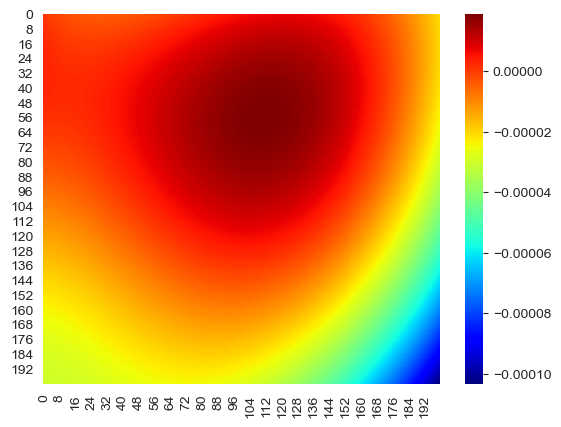

In [9]:
sns.heatmap(u_pred, cmap='jet')

<AxesSubplot: >

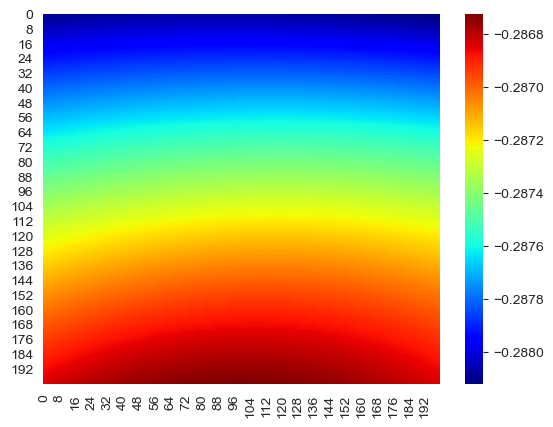

In [10]:
sns.heatmap(v_pred, cmap='jet')

<AxesSubplot: >

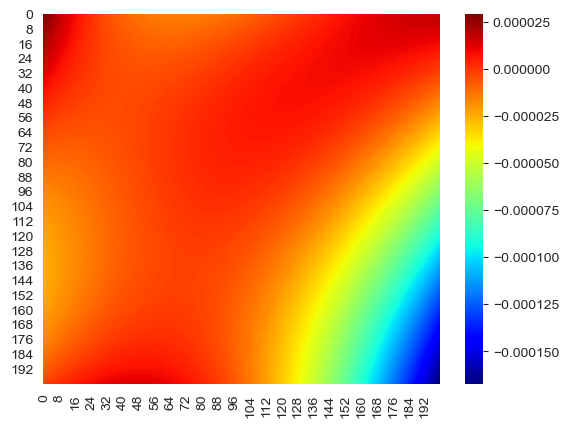

In [11]:
sns.heatmap(p_pred, cmap='jet')

In [12]:
mat = {'u': u_pred, 'v': v_pred, 'p': p_pred}
scipy.io.savemat('data\kovasznay_pinn.mat', mat)